In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

D:\Jupyter\anaconda3\envs\pytorch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using PyTorch version: 1.13.1+cu116  Device: cuda
X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


In [2]:
class MLP80(nn.Module):
    def __init__(self):
        super(MLP80, self).__init__()
        self.fc1 = nn.Linear(28*28, 80)
        self.fc2 = nn.Linear(80, 40)
        self.fc3 = nn.Linear(40, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.fc3(x), dim=1)

class MLP100(nn.Module):
    def __init__(self):
        super(MLP100, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.fc3(x), dim=1)

class MLP200(nn.Module):
    def __init__(self):
        super(MLP200, self).__init__()
        self.fc1 = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.fc3(x), dim=1)


def train(epoch, model, optimizer, log_interval=200):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

def validate(loss_vector, accuracy_vector, model):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


Training with learning rate: 0.01
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.305291
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.075376
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.926690
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.770717
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.590621
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.509966
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.517241
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.181591
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.322609
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.354698

Validation set: Average loss: 0.3221, Accuracy: 9069/10000 (91%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.309511
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.535892
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.159301
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.315335
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.206623
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.180795
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.566547
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.597675
Train Epoch

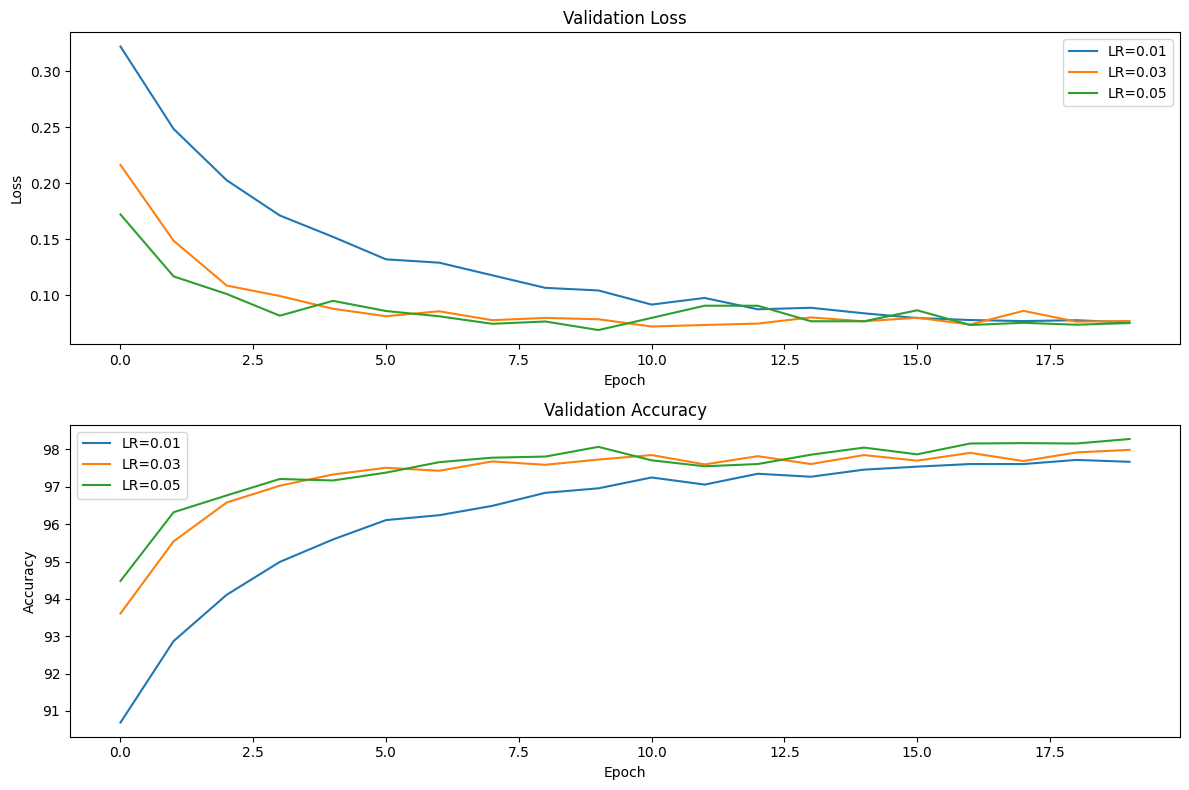

In [3]:
criterion = nn.CrossEntropyLoss()

# Assume MLP100() is the model you want to use for this experiment
model = MLP100().to(device)
learning_rates = [0.01, 0.03, 0.05]

loss_records = {lr: [] for lr in learning_rates}
accuracy_records = {lr: [] for lr in learning_rates}

for lr in learning_rates:
    # Note that for each learning rate, we need to create a new model and optimizer
    model = MLP100().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)
    print(f'Training with learning rate: {lr}')
    for epoch in range(20):
        train(epoch, model, optimizer)
        loss_vector, accuracy_vector = [], []
        validate(loss_vector, accuracy_vector, model)
        loss_records[lr].extend(loss_vector)
        accuracy_records[lr].extend(accuracy_vector)

        
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, figsize=(12, 8))

for lr in learning_rates:
    ax[0].plot(loss_records[lr], label=f'LR={lr}')
    ax[1].plot(accuracy_records[lr], label=f'LR={lr}')

ax[0].set_title('Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].set_title('Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

